In [128]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

import sys
sys.path.append("../") # go to parent dir
from samplers import memory_mnist, memory_fashion
from utils import expspace


In [129]:
def calculate_coeff(data, min_i, max_i, log=False, plot=False, show=False):
    data = np.array(data)
    data_clean = data[np.all(~np.isnan(data), axis=1)]
    ind_sort = np.argsort(data_clean[:,0])
    data_clean = data_clean[ind_sort]
    d, ll = tuple(zip(*data_clean))

    d = d[min_i:max_i]
    ll = ll[min_i:max_i]

    d = np.array(d).reshape(-1,1)
    ll = np.array(ll)
#     print(d)
    
    if log:
        d = np.log(d)
    regr = linear_model.LinearRegression()
    regr.fit(d, ll)
    ll_pred = regr.predict(d)

    if plot:
        plt.plot(d, regr.predict(d), label="prediction", c='r', alpha=0.5)
        plt.plot(d, ll, 'o-', alpha=0.5)
    if show:
        plt.show()
        
    return regr.coef_[0]


In [232]:
image_size = 32
n_pixel = image_size * image_size * 1
val_flag = True

n = 40
cls = 0

In [248]:
train_loader, val_loader, train_val_loader, train_labels, val_labels = memory_fashion(
    1, 32, 1, return_y=True
)
# train_loader, val_loader, train_val_loader, train_labels, val_labels = memory_mnist(
#     1, 32, 1, return_y=True
# )

# fnames = sorted(glob(f"../entropia/mnist-repaired/ll_*_{n}.*"))
# fnames = sorted(glob(f"../entropia/mnist-seq/seq_ll_*0.txt"))
# fnames = sorted(glob(f"../entropia/fashion-mnist/ll_*_{n}.*"))
fnames = sorted(glob(f"../entropia/fashion-seq/seq_ll_*0.txt"))

fnames = [f for f in fnames if int(f.split("_")[-1].split(".")[0])>=50]
fnames

['../entropia/fashion-seq/seq_ll_batch#64;n_channels#1;epochs#200;n_flow#32;n_block#4;no_lu#False;affine#True;n_bits#8;lr#5e-05;img_size#32;temp#0.7;n_sample#20;dataset#fashion_mnist;device#cuda:0;delta#0.007454880229115496_180.txt',
 '../entropia/fashion-seq/seq_ll_batch#64;n_channels#1;epochs#200;n_flow#32;n_block#4;no_lu#False;affine#True;n_bits#8;lr#5e-05;img_size#32;temp#0.7;n_sample#20;dataset#fashion_mnist;device#cuda:0;delta#0.009102821015130404_170.txt',
 '../entropia/fashion-seq/seq_ll_batch#64;n_channels#1;epochs#200;n_flow#32;n_block#4;no_lu#False;affine#True;n_bits#8;lr#5e-05;img_size#32;temp#0.7;n_sample#20;dataset#fashion_mnist;device#cuda:0;delta#0.01111504784609142_160.txt',
 '../entropia/fashion-seq/seq_ll_batch#64;n_channels#1;epochs#200;n_flow#32;n_block#4;no_lu#False;affine#True;n_bits#8;lr#5e-05;img_size#32;temp#0.7;n_sample#20;dataset#fashion_mnist;device#cuda:0;delta#0.013572088082974535_150.txt',
 '../entropia/fashion-seq/seq_ll_batch#64;n_channels#1;epochs#200

0: 1: 2: 3: 4: 5: 6: 7: 8: 9: 

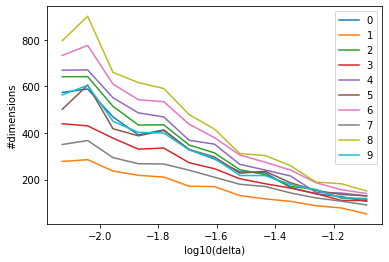

In [249]:
for cls in range(10):
    print(cls, end=": ")
    to_plot = []
    for f in fnames:
        txt = pd.read_csv(f, sep=" ", header=None)
        if val_flag:
            txt = txt[val_labels.numpy() == cls]
        else:
            txt = txt[train_labels[-5000:].numpy() == cls]
        if val_flag:
            noise, pz, logdet, _, _ = txt.mean()
        else:
            noise, _, _, pz, logdet = txt.mean()
        to_plot.append([noise, -(pz + logdet)])
    to_plot = np.array(to_plot)
    coef_list = [calculate_coeff(to_plot, i, i+2, log=True, plot=False) for i in range(len(to_plot)-1)]
    plt.plot(np.sort(np.log10(to_plot[:(len(to_plot)-1),0])), n_pixel - np.array(coef_list), label=cls)
    plt.xlabel("log10(delta)")
    plt.ylabel("#dimensions")
#     coef = calculate_coeff(to_plot, 7, 11, log=True, plot=False, show=False)
#     print(n_pixel - coef)
plt.legend();
# length = 2
# dims = []
# for i in range(0, len(to_plot)-length+1):
#     coef = calculate_coeff(to_plot, i, i + length, log=True, plot=False)
#     print(i, i + length, n_pixel - coef)
#     dims.append(n_pixel - coef)
# plt.plot(np.log10((to_plot[:-1, 0] + to_plot[1:, 0])/2), dims)

In [250]:
txt_list = []
for f in fnames:
    txt = pd.read_csv(f, sep=" ", header=None)
    txt_list.append(txt)
    
dims = []
for i in range(5000):
    if i % 1000 == 0:
        print(i)
    to_plot = []
    for txt in txt_list:
        if val_flag:
            noise, pz, logdet, _, _ = txt.iloc[i]
        else:
            noise, _, _, pz, logdet = txt.iloc[i]
        to_plot.append([noise, -(pz + logdet)])
    to_plot = np.array(to_plot)
    coef = coef = calculate_coeff(to_plot, 0, len(to_plot), log=True, plot=False)
    dims.append(n_pixel - coef)


0
1000
2000
3000
4000


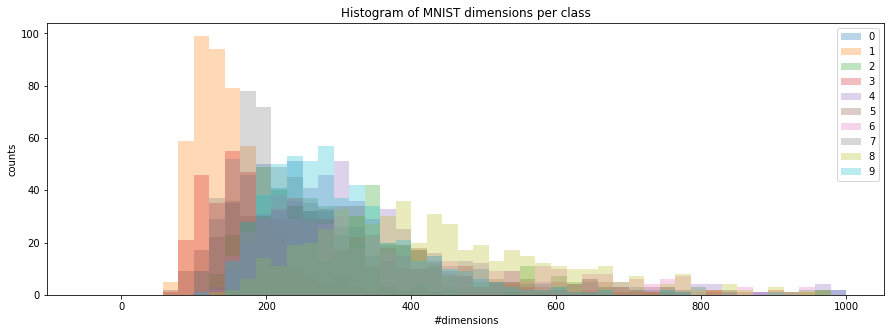

In [251]:
plt.figure(figsize=(15,5))
dims = np.array(dims)
for cls in range(10):
    if val_flag:
        plt.hist(dims[val_labels.numpy() == cls], bins=np.linspace(-50, 1000, 50), alpha = 0.3, label=str(cls));
    else:
        plt.hist(dims[train_labels[50000:].numpy() == cls], bins=np.linspace(-50, 1000, 50), alpha = 0.3, label=str(cls));
#     plt.show()
plt.legend()
plt.title("Histogram of MNIST dimensions per class")
plt.xlabel("#dimensions")
plt.ylabel("counts");

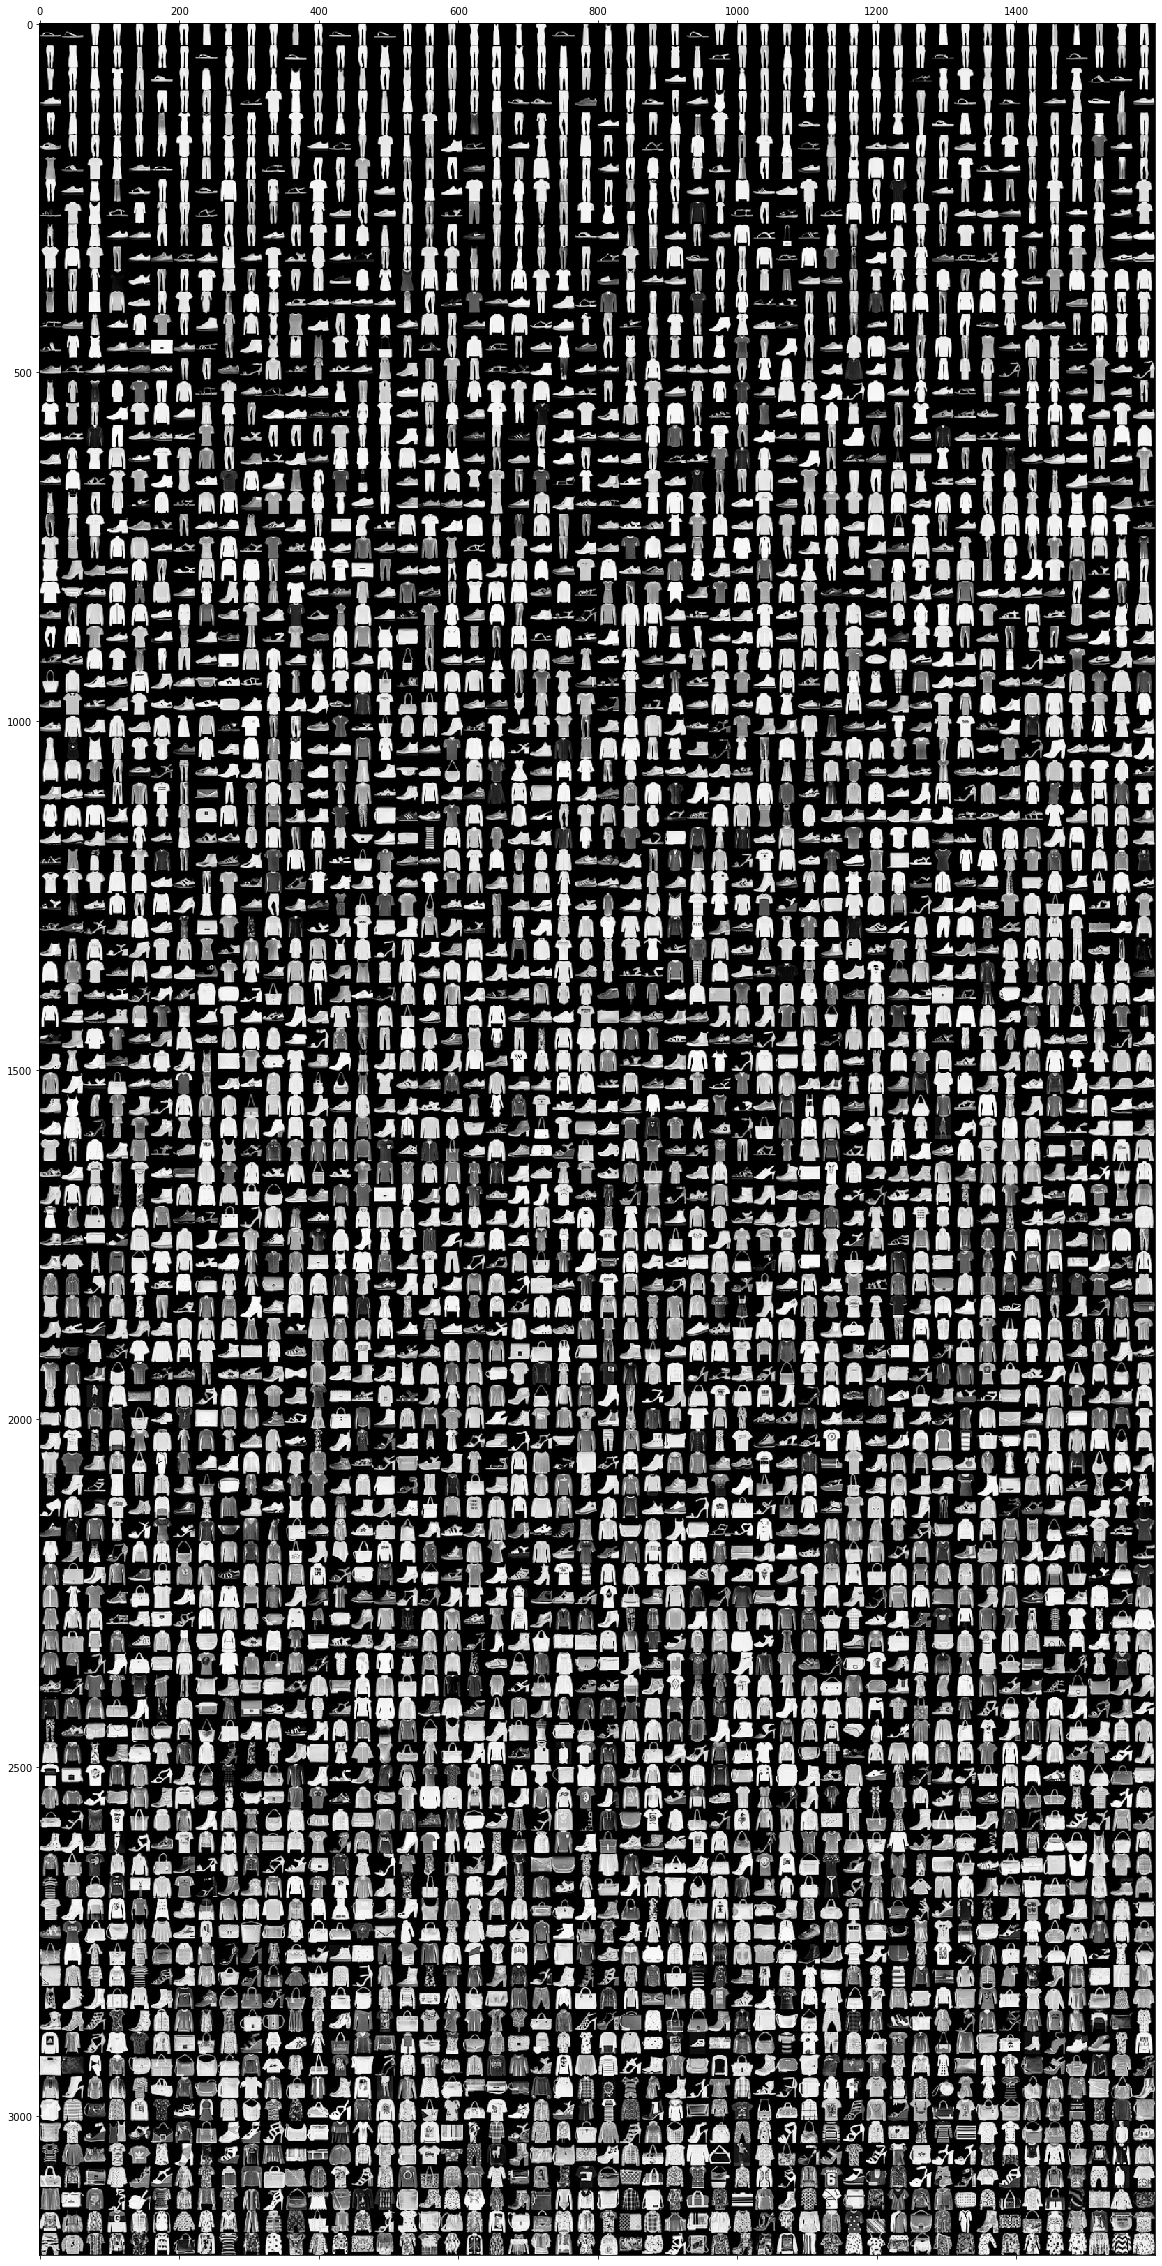

In [252]:
plt.figure(figsize=(20, 40))
m = 50
img_list = []
for i in range(0, 5000, m):
    imgs = []
    for j in range(m):
        ind = dims.argsort()[i + j]
        if val_flag:
            imgs.append(val_loader.dataset[ind][0])
        else:
            imgs.append(train_loader.dataset.tensors[50000:][ind])
    imgs = np.concatenate(imgs, axis=1)
    img_list.append(imgs)
plt.matshow(-np.concatenate(img_list, axis=0), fignum=1, cmap="Greys")
plt.show()

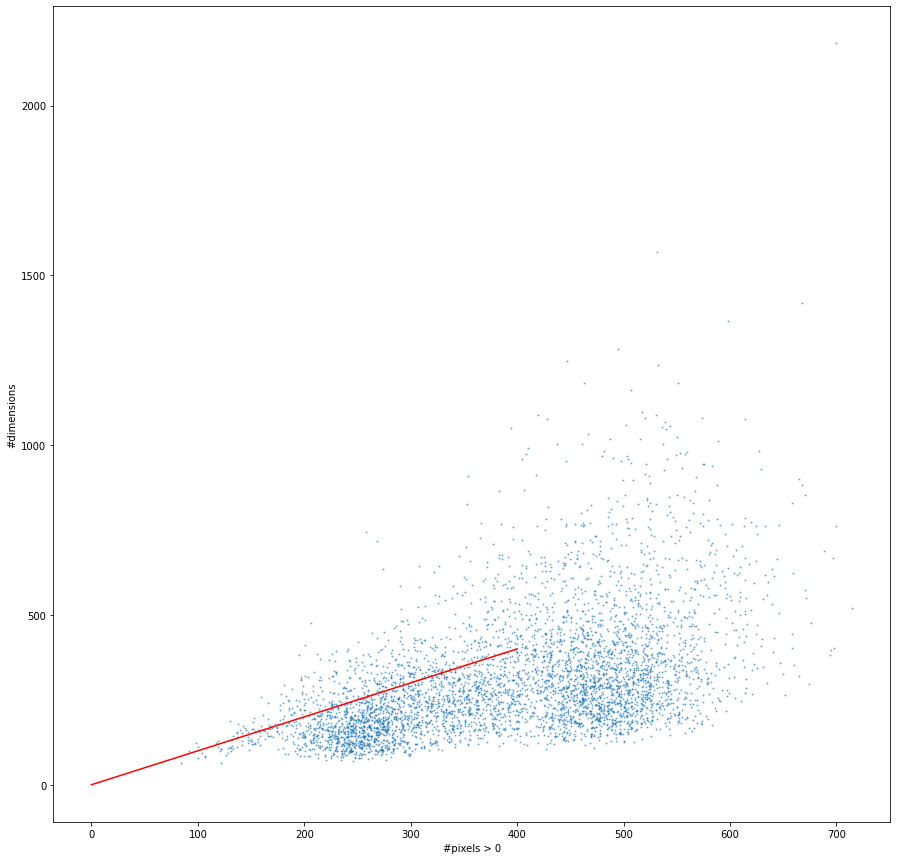

In [253]:
n_pix = []
for i in range(5000):
    n_pix.append((val_loader.dataset.tensors[i] > 0).sum().item())

plt.figure(figsize=(15,15))
plt.scatter(n_pix, dims, s=1, alpha=0.5)
plt.plot([0,400],[0,400], c='r')
plt.xlabel("#pixels > 0")
plt.ylabel("#dimensions");

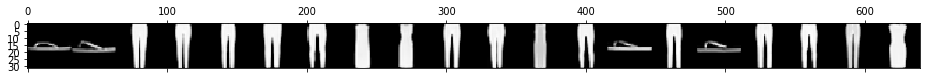

In [254]:
m = 20
imgs = []
for i in dims.argsort()[:m]:
    imgs.append(val_loader.dataset[i][0])

plt.matshow(-np.concatenate(imgs, axis=1), cmap="Greys")
plt.show()

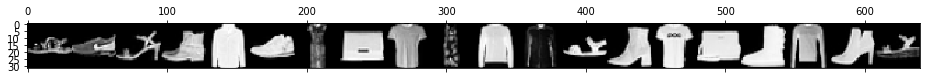

In [255]:
imgs = []
for i in dims.argsort()[2000:(2000+m)]:
    imgs.append(val_loader.dataset[i][0])
plt.matshow(-np.concatenate(imgs, axis=1), cmap="Greys")
plt.show()

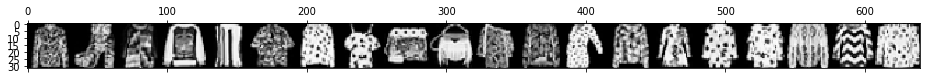

In [256]:
imgs = []
for i in dims.argsort()[-m:]:
    imgs.append(val_loader.dataset[i][0])
plt.matshow(-np.concatenate(imgs, axis=1), cmap="Greys")
plt.show()

In [282]:
def expspace(start, end, num):
    space = np.linspace(np.log(start), np.log(end), num)
    space = np.exp(space)
    return space

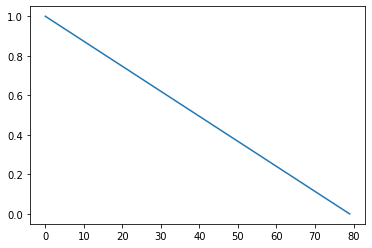

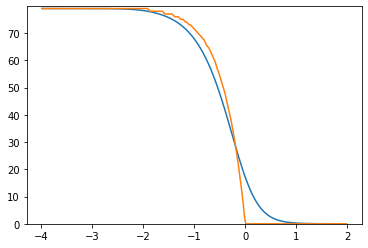

In [287]:
# sigma = [0] * 70 + [1] * 10
sigma = np.linspace(1, 0, 80)

plt.plot(sigma)
plt.show()

n_pixel = len(sigma)

to_plot = []
delta_dim  = []
for delta in expspace(0.0001, 100, 250):
    sigma = np.array(sigma)
    delta_arr = np.ones(sigma.shape[0]) * delta
    to_plot.append([delta, np.log(sigma**2 + delta_arr **2).sum()/2])
    delta_dim.append((sigma > delta).sum())
to_plot = np.array(to_plot)
delta_dim = np.array(delta_dim)

length = 2

dims = []
for i in range(0, len(to_plot)-length+1):
    coef = calculate_coeff(to_plot, i, i + length, log=True, plot=False)
#     print(i, i + length, n_pixel - coef)
    dims.append(n_pixel - coef)

plt.plot(np.log10((to_plot[:-1, 0] + to_plot[1:, 0])/2), dims)
plt.plot(np.log10((to_plot[:-1, 0] + to_plot[1:, 0])/2), (delta_dim[:-1] + delta_dim[1:])/2)
plt.ylim(0, np.max(dims) * 1.01);
# dims

In [271]:
l = 1/256
var = 1/12*(l)**2
sd = np.sqrt(var)
sd

0.0011276372445109878

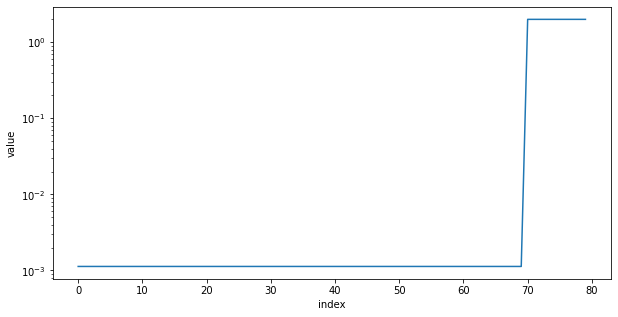

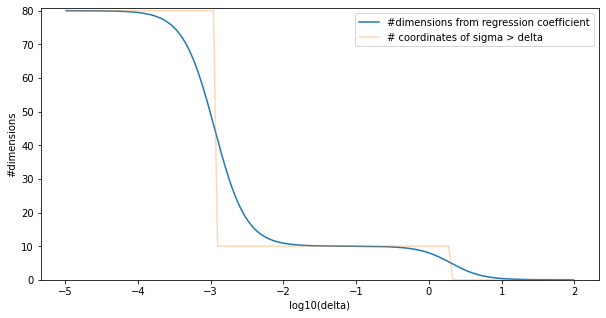

In [281]:
low = 0.00113
high = 2
sigma = [low] * 70 + [high] * 10
# sigma = np.linspace(1, 0, 80)

plt.figure(figsize=(10,5))
plt.plot(sigma)
plt.xlabel("index")
plt.ylabel("value")
plt.yscale("log")
plt.show()

n_pixel = len(sigma)

to_plot = []
delta_dim  = []
for delta in expspace(0.00001, 100, 250):
    sigma = np.array(sigma)
    delta_arr = np.ones(sigma.shape[0]) * delta
    to_plot.append([delta, np.log(sigma**2 + delta_arr **2).sum()/2])
    delta_dim.append((sigma > delta).sum())
to_plot = np.array(to_plot)
delta_dim = np.array(delta_dim)

length = 2

dims = []
for i in range(0, len(to_plot)-length+1):
    coef = calculate_coeff(to_plot, i, i + length, log=True, plot=False)
#     print(i, i + length, n_pixel - coef)
    dims.append(n_pixel - coef)

plt.figure(figsize=(10,5))
plt.plot(np.log10((to_plot[:-1, 0] + to_plot[1:, 0])/2), dims, label="#dimensions from regression coefficient")
plt.plot(np.log10((to_plot[:-1, 0] + to_plot[1:, 0])/2), (delta_dim[:-1] + delta_dim[1:])/2, alpha=0.3, label="# coordinates of sigma > delta")
plt.xlabel("log10(delta)")
plt.ylabel("#dimensions")
plt.ylim(0, np.max(dims) * 1.01);
plt.legend()

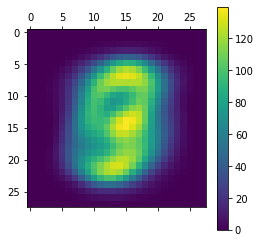

In [303]:
plt.matshow(train_loader.dataset.tensors.float().mean(axis=0))
plt.colorbar()

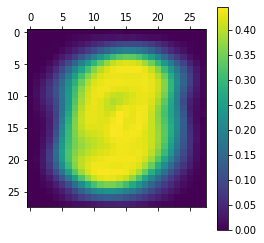

In [329]:
plt.matshow((train_loader.dataset.tensors.float()/255).std(axis=0))
plt.colorbar()

In [330]:
np.random.uniform(low=0, high=1/256, size=10000).std()

0.00112185726987694

In [333]:
10**(-1.5)

0.03162277660168379

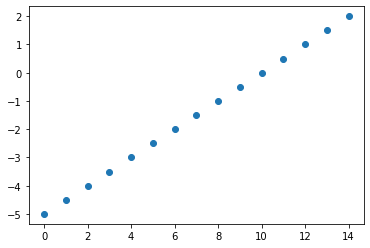

0.000000 0.000010 0.000032 0.000100 0.000316 0.001000 0.003162 0.010000 0.031623 0.100000 0.316228 1.000000 3.162278 10.000000 31.622777 100.000000 

In [293]:
noises = expspace(0.00001, 100, 15)
plt.plot(np.log10(noises), 'o')
plt.show()
for i in [0] + list(noises):
    print(f"{i:4f}", end=" ")